In [ ]:
!pip install pandas nltk
!python -m spacy download en_core_web_md

In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
# import all packages
import pandas as pd
import numpy as np
from glob import glob
import string
import re
import nltk
import json
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

nltk.download('punkt') # downloads the NLTK data for tokenization
nltk.download('stopwords') # downloads the NLTK data for stopwords
nltk.download('wordnet') # downloads the NLTK data for WordNet lemmatizer

In [6]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) # removes punctuation from the text using the translate method

    # Tokenize
    tokens = word_tokenize(text) # tokenizes the text into individual words

    # Remove stopwords
    stop_words = set(stopwords.words('english')) # creates a set of stopwords for English language
    tokens = [w for w in tokens if not w in stop_words] # removes stopwords from the list of tokens

    # Lemmatize
    lemmatizer = WordNetLemmatizer() # creates an instance of the WordNetLemmatizer
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # applies lemmatization to each token in the list
    return ' '.join(tokens)
    #return tokens

# Load the dataset
dataset = pd.read_json('/content/News_Category_Dataset_v3.json', lines=True)

df = pd.DataFrame(dataset)
#print(df)
#print("\n")
# Preprocess the news headline & short description
df['processed_text'] = df.apply(lambda row: preprocess_text(row['headline'] + " " + row['short_description']), axis=1)
print(df['processed_text'])

0         million american roll sleeve omicrontargeted c...
1         american airline flyer charged banned life pun...
2         funniest tweet cat dog week sept dog dont unde...
3         funniest tweet parent week sept accidentally p...
4         woman called cop black birdwatcher loses lawsu...
                                ...                        
209522    rim ceo thorsten heins significant plan blackb...
209523    maria sharapova stunned victoria azarenka aust...
209524    giant patriot jet colt among improbable super ...
209525    aldon smith arrested er linebacker busted duo ...
209526    dwight howard rip teammate magic loss hornet f...
Name: processed_text, Length: 209527, dtype: object


In [7]:
import json
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

processed_text = df['processed_text'].tolist()

# Word2Vec Vectorization
tokenized_articles = [text.split() for text in processed_text]
word2vec_model = Word2Vec(tokenized_articles, vector_size=100, window=5, min_count=1, workers=4)

document_vector = []
for article in tokenized_articles:
    for word in article:
        if word in word2vec_model.wv.key_to_index:
            document_vector.append(word2vec_model.wv[word])

# Convert the list of Word2Vec vectors to a numpy array
document_vector = np.array(document_vector)
print(document_vector[:1000])

[[-5.1805264e-01 -2.4208724e+00  1.9712038e+00 ...  1.5407066e-01
   2.3677659e+00  1.7741296e+00]
 [-1.3063356e+00 -6.6467124e-01  8.7410158e-01 ...  1.2033305e+00
  -3.2225215e+00 -6.7398697e-01]
 [-4.5349208e-01  1.6547754e-01  6.3276851e-01 ... -1.2663056e+00
  -1.9505844e-02  9.5511103e-01]
 ...
 [-5.0259009e-03  1.0749680e-02  3.7834398e-02 ... -2.5933072e-02
   1.8667635e-02  3.1520424e-03]
 [-3.1049877e-01  2.9112440e-01  6.1825085e-01 ... -6.9788849e-01
   2.8065753e-01  5.9713256e-01]
 [-4.2422274e-01  3.9060108e-02  1.5635446e-01 ... -5.7224047e-01
   2.6263532e-01  4.4900844e-01]]


[[-4.0782714  -0.57813185]
 [ 0.14146473  2.206384  ]
 [-3.3625593  -1.4858991 ]
 ...
 [ 1.8035704  -0.38087496]
 [ 3.0188758   1.4274344 ]
 [ 2.9623191   0.50012773]]




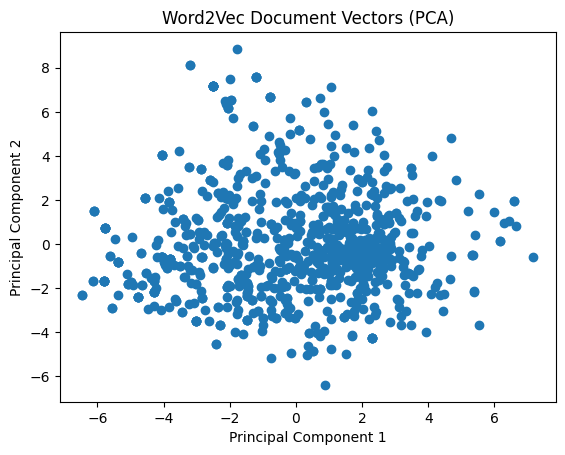

In [8]:
# Take a subset of 1000 data points
n_samples = 1000
if document_vector.shape[0] > n_samples:
    indices = np.random.choice(document_vector.shape[0], n_samples, replace=False)
    document_vector = document_vector[indices]

# Apply PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
document_vector_pca = pca.fit_transform(document_vector)
print(document_vector_pca)
print("\n")

# Plot the document vectors in a scatter plot
plt.scatter(document_vector_pca[:, 0], document_vector_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Word2Vec Document Vectors (PCA)')
plt.show()

In [ ]:
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import warnings

# Preprocess the data
scaler = StandardScaler()
document_vector_scaled = scaler.fit_transform(document_vector_pca)

# Check the number of distinct samples in the dataset
unique_samples = np.unique(document_vector_scaled, axis=0)
n_samples = unique_samples.shape[0]

# Check if the number of clusters is valid
n_clusters = 42
if n_clusters > n_samples:
    n_clusters = n_samples

# Disable ConvergenceWarnings for demonstration purposes
warnings.filterwarnings("ignore", category=UserWarning)

# K-means clustering
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(unique_samples)

# Agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
agglomerative_labels = agglomerative.fit_predict(unique_samples)

# GMM clustering
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(unique_samples)
gmm_labels = gmm.predict(unique_samples)

# Enable ConvergenceWarnings
warnings.filterwarnings("default", category=UserWarning)

# Print the labels assigned by each clustering algorithm
print("K-means labels:", kmeans_labels)
print("Agglomerative labels:", agglomerative_labels)
print("GMM labels:", gmm_labels)

K-means Calinski-Harabasz Index: 1.2885138561637464
Agglomerative Calinski-Harabasz Index: 1.420448646230081
GMM Calinski-Harabasz Index: 1.1136702907716984


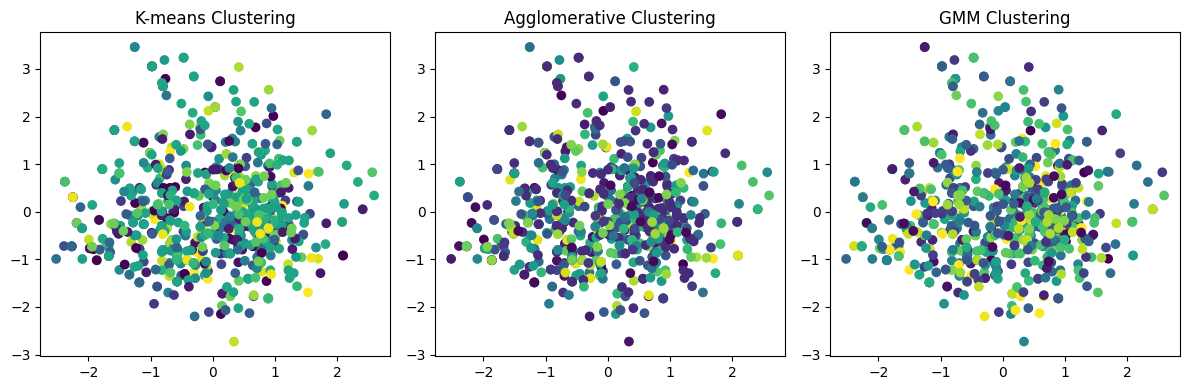

Best Clustering Algorithm based on Calinski-Harabasz Index: Agglomerative


In [13]:
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt

# Subset the clustering labels to match the number of samples
kmeans_labels_subset = kmeans_labels[:n_samples]
agglomerative_labels_subset = agglomerative_labels[:n_samples]
gmm_labels_subset = gmm_labels[:n_samples]

# Calculate Calinski-Harabasz scores
kmeans_ch_score = calinski_harabasz_score(document_vector_scaled[:n_samples], kmeans_labels_subset)
agglomerative_ch_score = calinski_harabasz_score(document_vector_scaled[:n_samples], agglomerative_labels_subset)
gmm_ch_score = calinski_harabasz_score(document_vector_scaled[:n_samples], gmm_labels_subset)

# Print the Calinski-Harabasz scores
print("K-means Calinski-Harabasz Index:", kmeans_ch_score)
print("Agglomerative Calinski-Harabasz Index:", agglomerative_ch_score)
print("GMM Calinski-Harabasz Index:", gmm_ch_score)

# Plot the clustering results
plt.figure(figsize=(12, 4))

# K-means clustering
plt.subplot(1, 3, 1)
plt.scatter(document_vector_scaled[:n_samples, 0], document_vector_scaled[:n_samples, 1], c=kmeans_labels_subset)
plt.title("K-means Clustering")

# Agglomerative clustering
plt.subplot(1, 3, 2)
plt.scatter(document_vector_scaled[:n_samples, 0], document_vector_scaled[:n_samples, 1], c=agglomerative_labels_subset)
plt.title("Agglomerative Clustering")

# GMM clustering
plt.subplot(1, 3, 3)
plt.scatter(document_vector_scaled[:n_samples, 0], document_vector_scaled[:n_samples, 1], c=gmm_labels_subset)
plt.title("GMM Clustering")

plt.tight_layout()
plt.show()

# Determine the best clustering algorithm based on the Calinski-Harabasz index
best_ch_score = max(kmeans_ch_score, agglomerative_ch_score, gmm_ch_score)
best_algorithm = None

if best_ch_score == kmeans_ch_score:
    best_algorithm = "K-means"
elif best_ch_score == agglomerative_ch_score:
    best_algorithm = "Agglomerative"
else:
    best_algorithm = "GMM"

print("Best Clustering Algorithm based on Calinski-Harabasz Index:", best_algorithm)

K-means Calinski-Harabasz Index: 1.0968882490134233
Agglomerative Calinski-Harabasz Index: 1.5344277358079497
GMM Calinski-Harabasz Index: 1.186347438271211


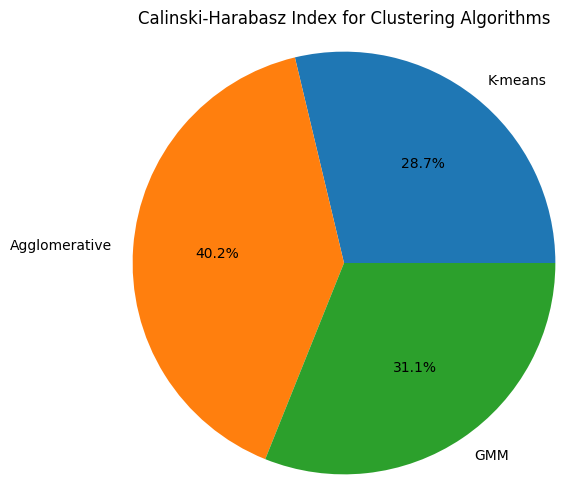

In [15]:
print("K-means Calinski-Harabasz Index:", kmeans_ch_score)
print("Agglomerative Calinski-Harabasz Index:", agglomerative_ch_score)
print("GMM Calinski-Harabasz Index:", gmm_ch_score)

# Plot the Calinski-Harabasz index as a pie chart
labels = ["K-means", "Agglomerative", "GMM"]
scores = [kmeans_ch_score, agglomerative_ch_score, gmm_ch_score]

# Set the figure size
plt.figure(figsize=(6, 6))

plt.pie(scores, labels=labels, autopct='%1.1f%%')
plt.title("Calinski-Harabasz Index for Clustering Algorithms")
plt.axis('equal')
plt.show()

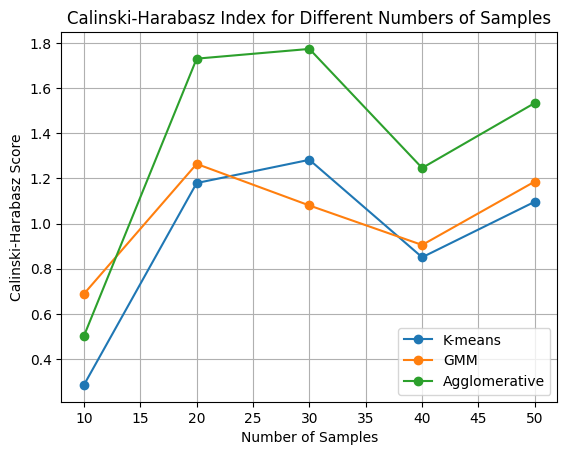

In [14]:
import matplotlib.pyplot as plt

# Define a list of numbers of samples
sample_sizes = [10, 20, 30, 40, 50]

# Initialize empty lists to store the Calinski-Harabasz scores for each algorithm
ch_scores_kmeans = []
ch_scores_gmm = []
ch_scores_agglomerative = []

# Calculate the Calinski-Harabasz scores for each number of samples
for n in sample_sizes:
    kmeans_ch_score = calinski_harabasz_score(document_vector_scaled[:n], kmeans_labels_subset[:n])
    gmm_ch_score = calinski_harabasz_score(document_vector_scaled[:n], gmm_labels_subset[:n])
    agglomerative_ch_score = calinski_harabasz_score(document_vector_scaled[:n], agglomerative_labels_subset[:n])

    ch_scores_kmeans.append(kmeans_ch_score)
    ch_scores_gmm.append(gmm_ch_score)
    ch_scores_agglomerative.append(agglomerative_ch_score)

# Plot the Calinski-Harabasz scores for each algorithm
plt.plot(sample_sizes, ch_scores_kmeans, marker='o', label='K-means')
plt.plot(sample_sizes, ch_scores_gmm, marker='o', label='GMM')
plt.plot(sample_sizes, ch_scores_agglomerative, marker='o', label='Agglomerative')
plt.xlabel('Number of Samples')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Index for Different Numbers of Samples')
plt.legend()
plt.grid(True)
plt.show()